In [1]:
from load_data import *
from mne.stats import permutation_cluster_1samp_test

testType = 'wilcoxon'

trials = behavior[~behavior.excluded]
pupils = samples.merge(trials, left_on=['subjectId', 'session', 'Trial'], right_on=['subjectId', 'session', 'trialCount'])

In [2]:
def compareWithinSubject(s, condType1, condType2, testType='t', sigLevel=0.05, title=None, minOffset='-0.5s', maxOffset='5s', ax=None):
    minOffset = max(pd.to_timedelta(minOffset), s.groupby(['subjectId', 'session', 'trialCount']).offsetFromStim.min().max())
    maxOffset = min(pd.to_timedelta(maxOffset), s.groupby(['subjectId', 'session', 'trialCount']).offsetFromStim.max().min())
    s = s[s.offsetFromStim.between(minOffset, maxOffset)]
    
    if ax is None:
        ax = plt.figure(figsize=(6, 5), dpi=100).subplots()
    if title:
        ax.set_title(title)
        print(f'********** {title} **********')
    ax.set_xlabel('Time relative to cue onset [sec]')
    ax.set_ylabel('Pupil size change [mm]')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    xValues = s.groupby('offsetFromStim').first().index.to_series() / pd.to_timedelta('1s')
    sg = s.groupby(['condType', 'offsetFromStim', 'subjectId']).Pupil.mean()
    for condType in (condType1, condType2):
        aggVals = sg.loc[condType].groupby('offsetFromStim').agg(['mean', 'sem'])
        color = condColors[condType]
        ax.plot(xValues, aggVals['mean'], color=color, label=condType)
        ax.fill_between(xValues, aggVals['mean'] - aggVals['sem'], aggVals['mean'] + aggVals['sem'], alpha=0.2, linewidth=0, color=color)

    ax.axvline(0., ls=':', color='grey')
    xFeedback = 4.
    if xValues.iloc[-1] > xFeedback:
        ax.axvline(xFeedback, ls=':', color='grey')

    c1 = sg.loc[condType1].unstack('offsetFromStim').to_numpy()
    c2 = sg.loc[condType2].unstack('offsetFromStim').to_numpy()
    if testType == 't':
        _, clusters, cluster_p_values, _ = permutation_cluster_1samp_test(
            c1 - c2,
            seed=42,
            n_permutations=1000,
            threshold=stats.distributions.t.ppf(1 - sigLevel / 2, df=c1.shape[0] - 1),
            tail=0,
            n_jobs=None,
            out_type='mask')
    else:
        wilcox = lambda x: stats.wilcoxon(x, method='approx').zstatistic
        _, clusters, cluster_p_values, _ = permutation_cluster_1samp_test(
            c1 - c2,
            seed=42,
            n_permutations=1000,
            stat_fun=wilcox,
            threshold=stats.distributions.norm.ppf(1 - sigLevel / 2),
            tail=0,
            n_jobs=None,
            out_type='mask')
    #print(clusters, cluster_p_values)

    yPos = ax.get_ylim()[0]
    for c, p in zip(clusters, cluster_p_values):
        c = c[0]
        xMin, xMax = xValues.iloc[c.start], xValues.iloc[c.stop - 1]
        if p < sigLevel:
            ax.hlines(yPos, xMin, xMax, color='black', linewidth=4)
            print(f'Significant cluster from {xMin} to {xMax} seconds (p={p}).')
        else:
            #ax.hlines(yPos, xMin, xMax, color='black', linewidth=4, alpha=0.2)
            print(f'Non-significant cluster from {xMin} to {xMax} seconds (p={p}).')
            
    ax.legend(frameon=True, loc='upper left')

In [3]:
def baselineCorrect(df, baselineStart='-0.5s', baselineEnd='0s'):
    trialKeyFields = ['subjectId', 'session', 'trialCount']
    baseData = df[df.offsetFromStim.between(pd.to_timedelta(baselineStart), pd.to_timedelta(baselineEnd))]
    baseline = baseData.groupby(trialKeyFields, as_index=False).Pupil.mean()
    corrected = df.merge(baseline.rename(columns={'Pupil': 'Baseline'}), on=trialKeyFields)
    corrected.Pupil = corrected.Pupil - corrected.Baseline
    return corrected.drop(columns='Baseline')

In [4]:
corrPupils = baselineCorrect(pupils)

********** A) Experimental session **********
stat_fun(H1): min=-3.9292039168398816 max=-0.0
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Non-significant cluster from -0.4 to -0.36 seconds (p=0.448).
Non-significant cluster from -0.04 to 0.02 seconds (p=0.386).
Significant cluster from 1.12 to 2.06 seconds (p=0.03).
********** B) Visual control session **********
stat_fun(H1): min=-1.5247656990721927 max=-0.0
Running initial clustering …
Found 0 clusters


C:\Users\gabor\AppData\Local\Temp\ipykernel_1800\301883602.py:42: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  _, clusters, cluster_p_values, _ = permutation_cluster_1samp_test(


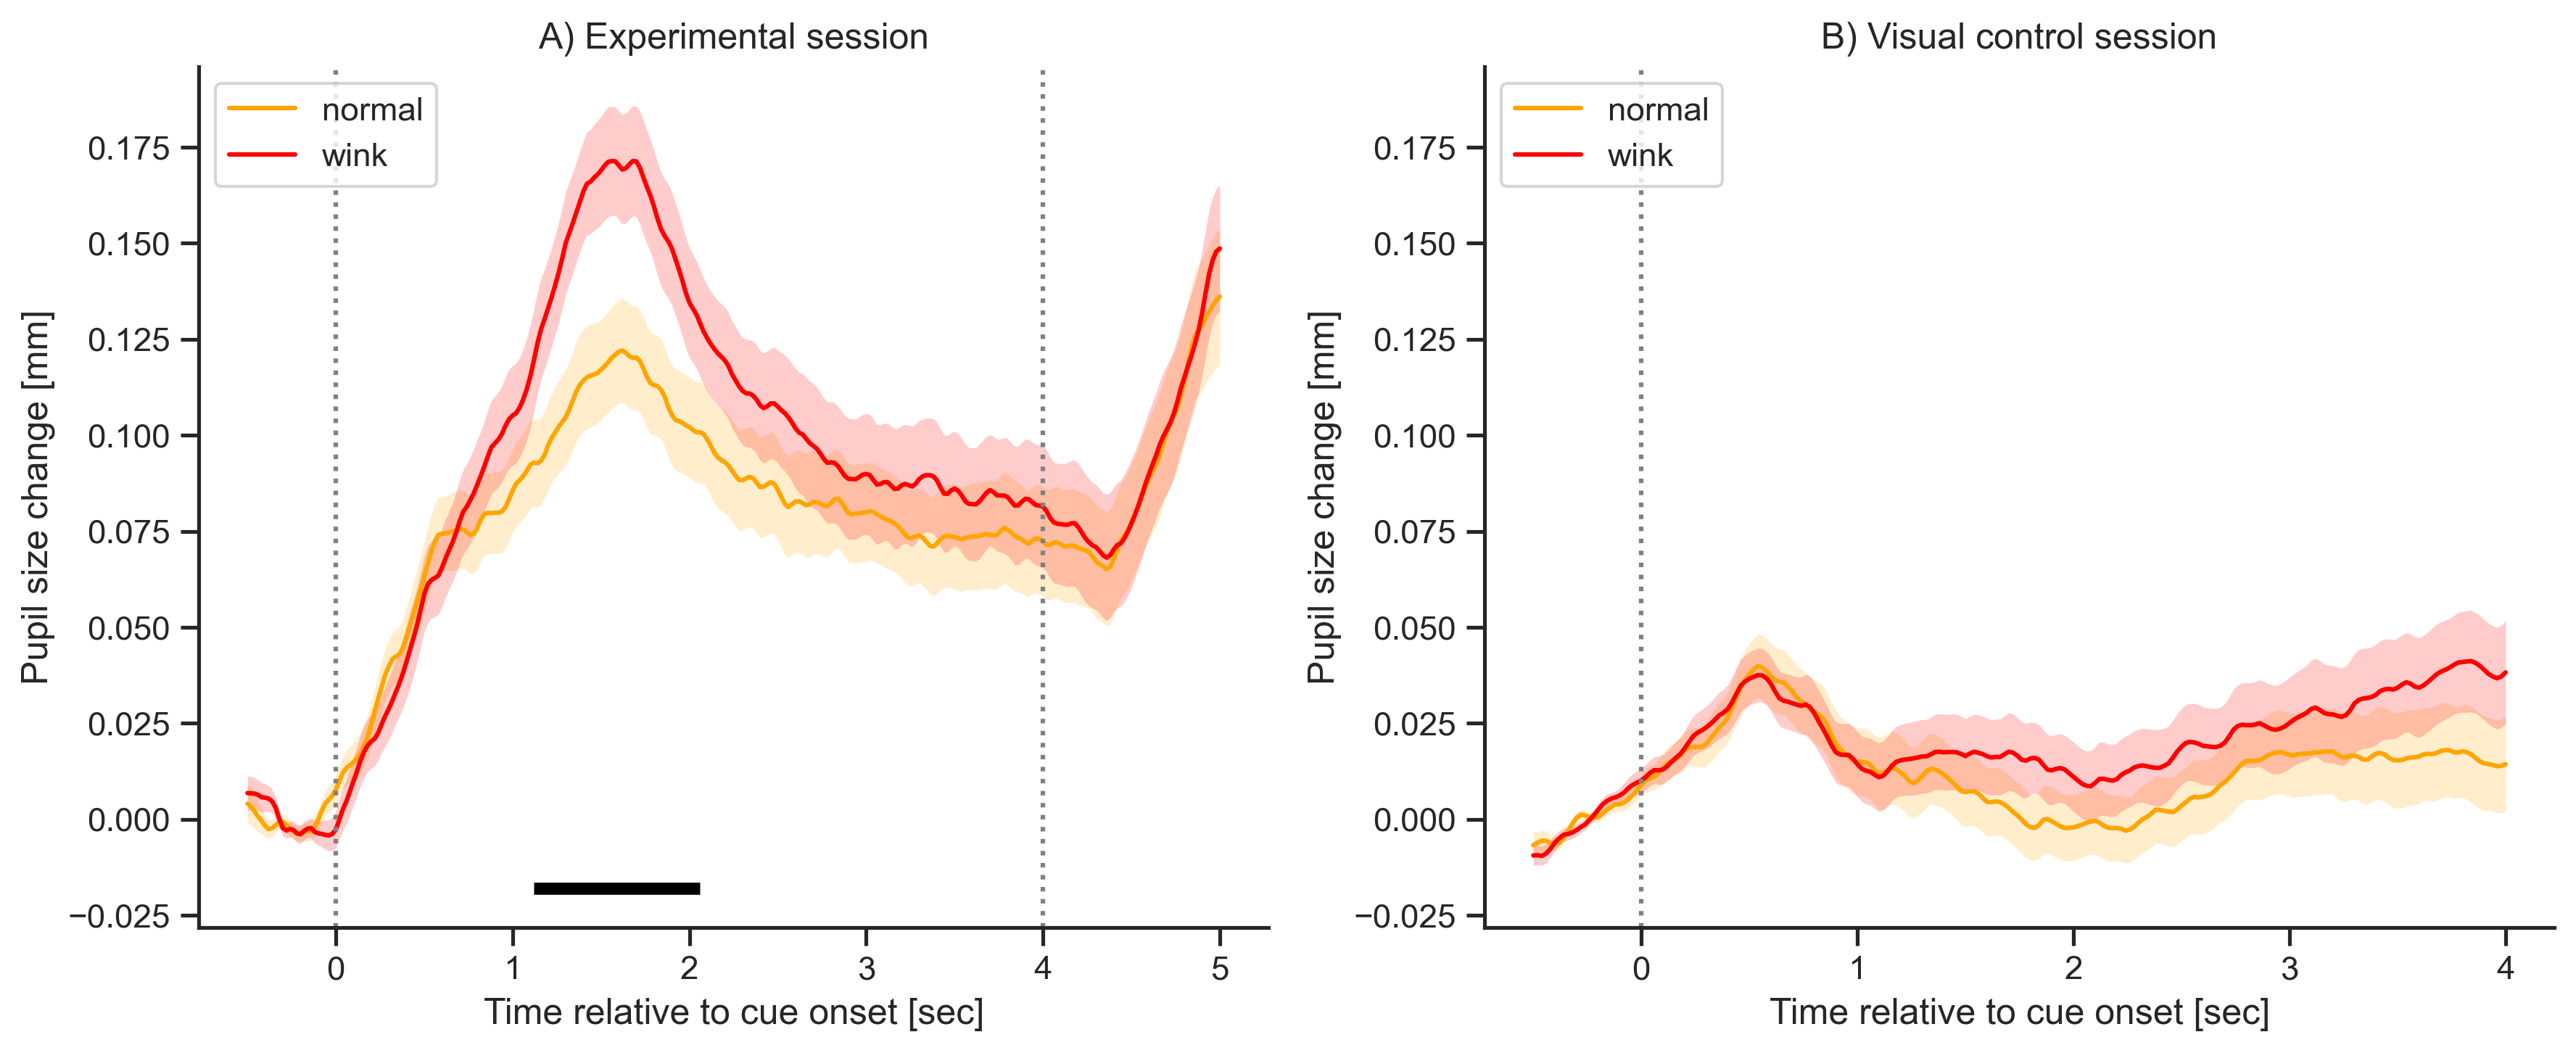

In [5]:
fig = plt.figure(figsize=(12, 5), dpi=300)
ax1, ax2 = fig.subplots(nrows=1, ncols=2)
compareWithinSubject(corrPupils[corrPupils.session=='experiment'], 'normal', 'wink', testType=testType, title=f'A) Experimental session', ax=ax1)
compareWithinSubject(corrPupils[corrPupils.session=='visual'], 'normal', 'wink', testType=testType, title=f'B) Visual control session', ax=ax2)

yLim = min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(yLim)
ax2.set_ylim(yLim)

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
fig.savefig(os.path.join(output_dir, 'figure3.png'))
fig.savefig(os.path.join(output_dir, 'figure3.pdf'))

In [6]:
print('Subjects not selecting the preferred option in more than half of both normal and wink trials:')
checkedTrials = behavior[(behavior.session=='experiment') & behavior.condType.isin(['normal', 'wink'])].copy()
checkedTrials['prefSel'] = (checkedTrials.response==checkedTrials.preferred)
minProportions = checkedTrials.groupby(['subjectId', 'condType']).prefSel.mean().groupby('subjectId').min()
excSubjects = minProportions[minProportions <= 0.5].index.tolist()
print('\t', excSubjects)

Subjects not selecting the preferred option in more than half of both normal and wink trials:
	 [4006, 5008, 5015, 5033, 5034, 5038, 5041, 5047, 8001, 8006, 8016, 8020, 8021, 8025]


********** Preferred selection trials of subjects selecting preferred >50% of trials in both conditions **********
stat_fun(H1): min=-4.002648191873738 max=-0.003267467911733664
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Non-significant cluster from -0.08 to 0.0 seconds (p=0.388).
Non-significant cluster from 0.88 to 0.88 seconds (p=0.611).
Significant cluster from 0.92 to 2.0 seconds (p=0.031).


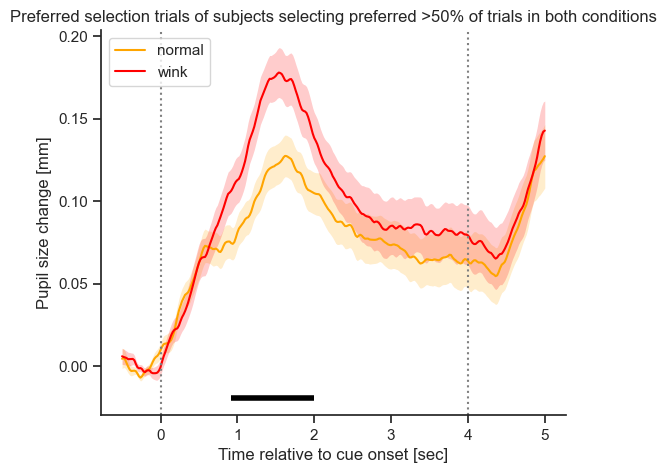

In [7]:
excPupils = corrPupils[~corrPupils.subjectId.isin(excSubjects) & (corrPupils.session=='experiment') & (corrPupils.response==corrPupils.preferred)]
excTitle = 'Preferred selection trials of subjects selecting preferred >50% of trials in both conditions'
compareWithinSubject(excPupils, 'normal', 'wink', testType=testType, title=excTitle)

********** A) Experimental session **********
stat_fun(H1): min=-5.766742067003806 max=-0.00977413909661662
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Significant cluster from 1.18 to 5.0 seconds (p=0.001).
********** B) Visual control session **********
stat_fun(H1): min=-2.4972925391855467 max=-0.00488706954830831
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Non-significant cluster from 1.58 to 2.22 seconds (p=0.078).
Non-significant cluster from 2.32 to 2.46 seconds (p=0.211).
Non-significant cluster from 3.32 to 3.34 seconds (p=0.431).
Non-significant cluster from 3.72 to 3.82 seconds (p=0.256).


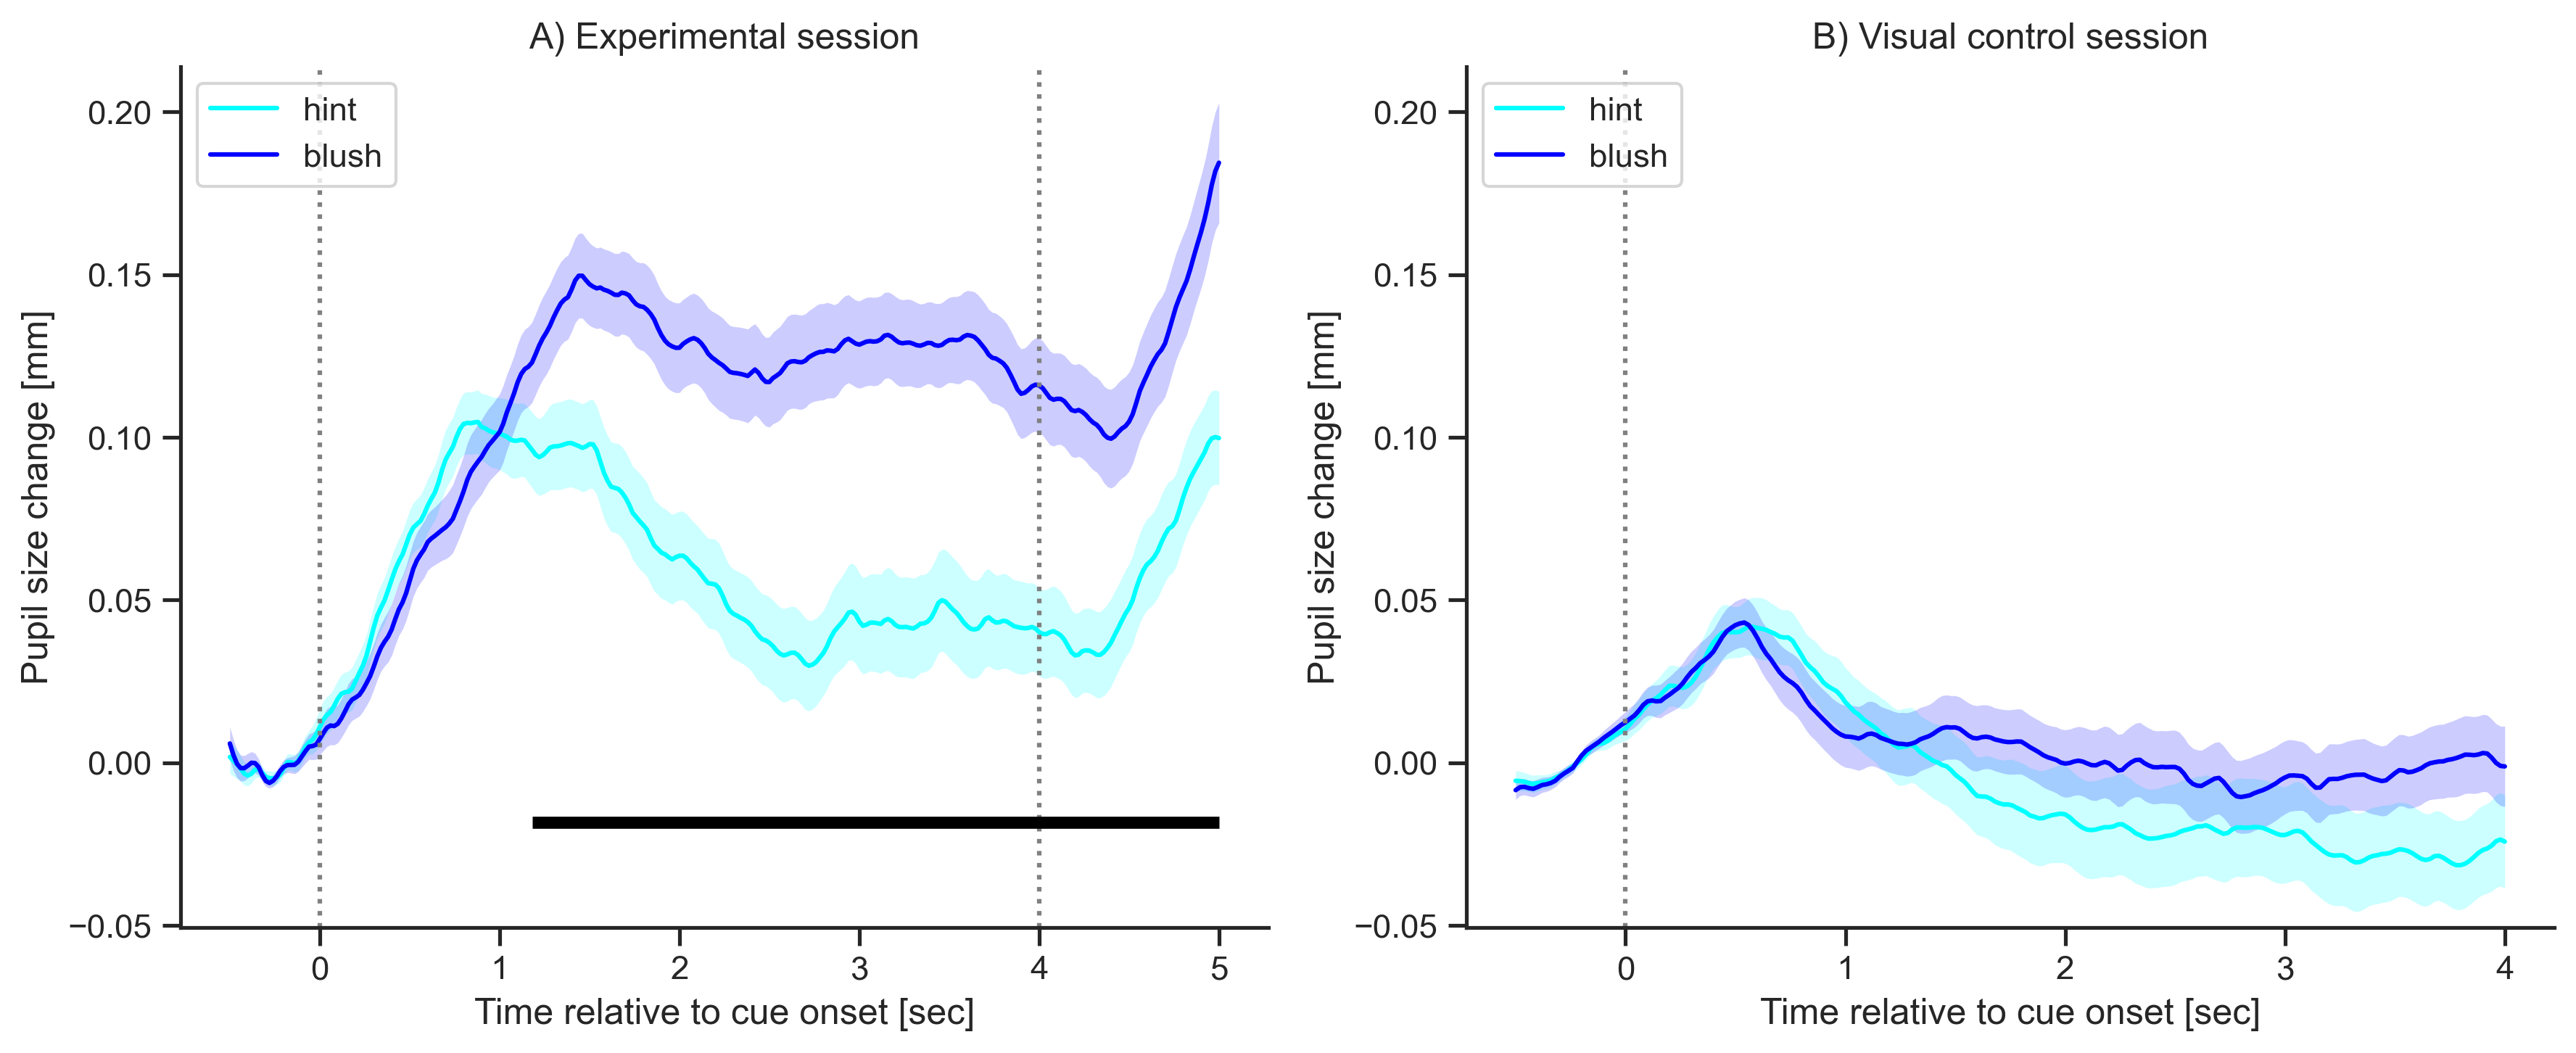

In [8]:
fig = plt.figure(figsize=(12, 5), dpi=300)
ax1, ax2 = fig.subplots(nrows=1, ncols=2)
compareWithinSubject(corrPupils[corrPupils.session=='experiment'], 'hint', 'blush', testType=testType, title=f'A) Experimental session', ax=ax1)
compareWithinSubject(corrPupils[corrPupils.session=='visual'], 'hint', 'blush', testType=testType, title=f'B) Visual control session', ax=ax2)

yLim = min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(yLim)
ax2.set_ylim(yLim)

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
fig.savefig(os.path.join(output_dir, 'figure4.png'))
fig.savefig(os.path.join(output_dir, 'figure4.pdf'))